In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import *

In [2]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    

In [3]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):

    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

In [4]:
datasets = ['input']

class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [5]:
def load_data():
    images, labels = [], []
    
    for dataset in datasets:
        
        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(dataset,folder,file)
                
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (48,48))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass
    
    return (images, labels)
    pass

In [6]:
(images, labels) = load_data()
images.shape, labels.shape

100%|██████████| 1000/1000 [00:00<00:00, 2476.42it/s]


((4000, 48, 48, 3), (4000,))

In [7]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,3000
ship,1000


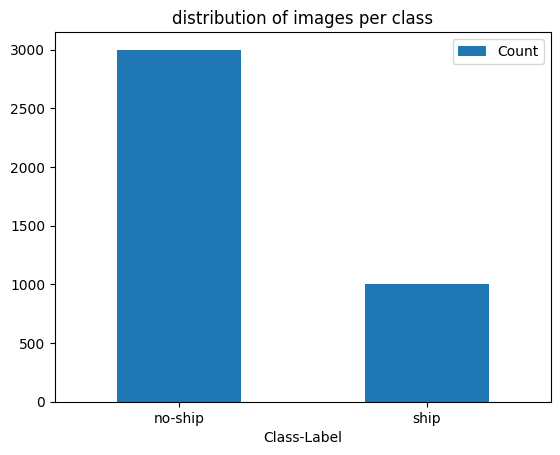

In [8]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

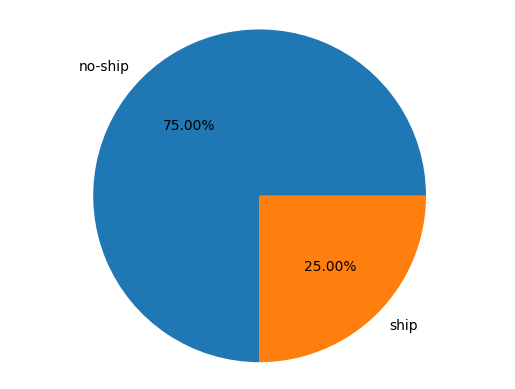

In [9]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

In [10]:
AUGMENTATION = True

In [11]:
def augment_add(images, seq, labels):
    
    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):
        
        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass
    
    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)
    
    return (augmented_images, augmented_labels)
    pass

In [12]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True) #filteri se random primenjuju

In [13]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

4000it [00:03, 1311.63it/s] 


In [14]:
images.shape, labels.shape

((6000, 48, 48, 3), (6000,))

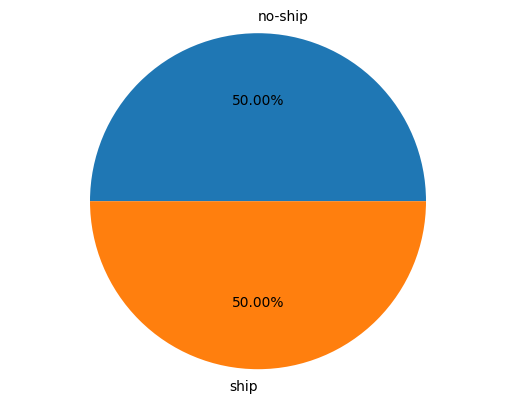

In [15]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');

In [16]:
labels = to_categorical(labels)

In [17]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

In [18]:
total_count = len(images)

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((4200, 48, 48, 3), (1200, 48, 48, 3), (600, 48, 48, 3))

In [19]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0) #sabira sve keceve

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

In [20]:
def conv_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'conv_' + str(stage)+block+'_branch'
    bn_base_name = 'bn_'+str(stage)+block+"_branch"
    
    F1 = filters
    
    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)
    
    return X
    pass

In [21]:
def basic_model(input_shape,classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((5,5))(X_input)
    
    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)
    
    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    
#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    
#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(128)(X)
    X = Activation("relu")(X)
    
    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)
    
    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')
    
    return model
    pass

In [22]:
model = basic_model(input_shape=(48,48,3),classes=2)

In [23]:
#plot_model(model,to_file='basic_model.png')

model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 58, 58, 3)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 29, 29, 16)       64        
 n)                                                              
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNormal  (None, 29, 

In [24]:
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")  # ispisivanje metrike po eposi

In [26]:
epochs = 50
batch_size = 16

history = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1, 
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs]
#                    class_weight=classWeight # odkomentarisati ako je AUGMENTATION = FALSE
                   )

Epoch 1/50
261/262 [============================>.] - ETA: 0s - loss: 0.3982 - accuracy: 0.8154
Epoch 1: val_accuracy improved from -inf to 0.69333, saving model to model_weights.h5
262/262 [==============================] - 9s 32ms/step - loss: 0.3975 - accuracy: 0.8155 - val_loss: 0.5261 - val_accuracy: 0.6933
Epoch 2/50
262/262 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9144
Epoch 2: val_accuracy improved from 0.69333 to 0.95667, saving model to model_weights.h5
262/262 [==============================] - 9s 34ms/step - loss: 0.1986 - accuracy: 0.9144 - val_loss: 0.1201 - val_accuracy: 0.9567
Epoch 3/50
262/262 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9432
Epoch 3: val_accuracy did not improve from 0.95667
262/262 [==============================] - 9s 33ms/step - loss: 0.1593 - accuracy: 0.9432 - val_loss: 0.0962 - val_accuracy: 0.9567
Epoch 4/50
262/262 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0

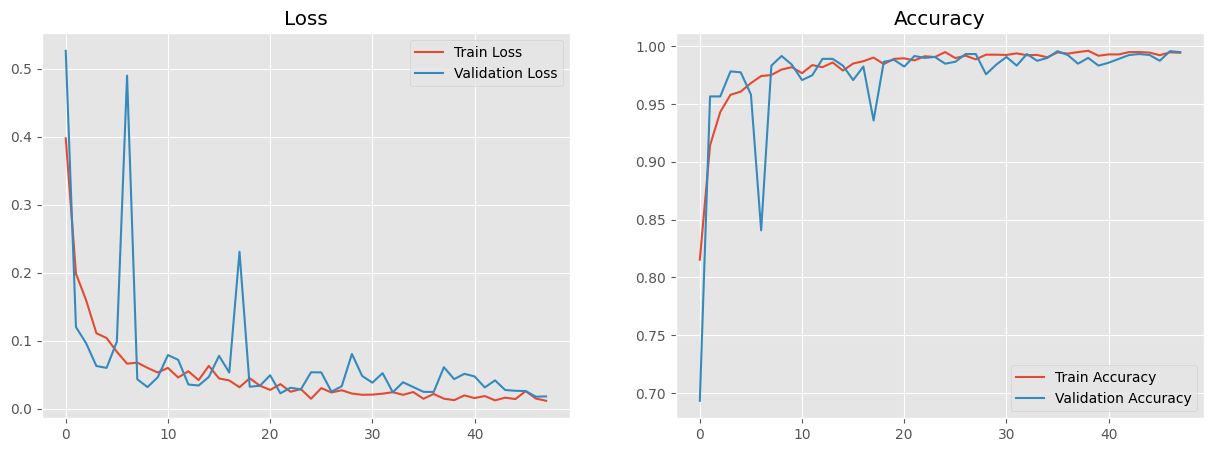

In [27]:
show_final_history(history)

In [28]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred,axis=1)
val_pred.shape

38/38 [==============================] - 1s 10ms/step


(1200,)

<Figure size 640x480 with 0 Axes>

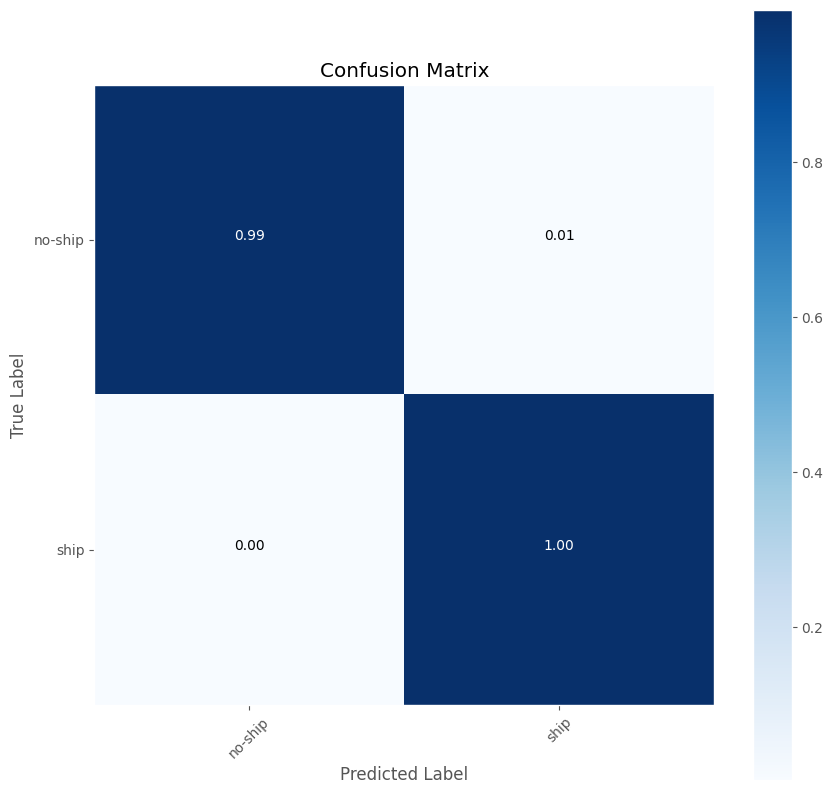

In [29]:
val_actual = np.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

In [30]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

19/19 [==============================] - 0s 9ms/step


(600,)

<Figure size 640x480 with 0 Axes>

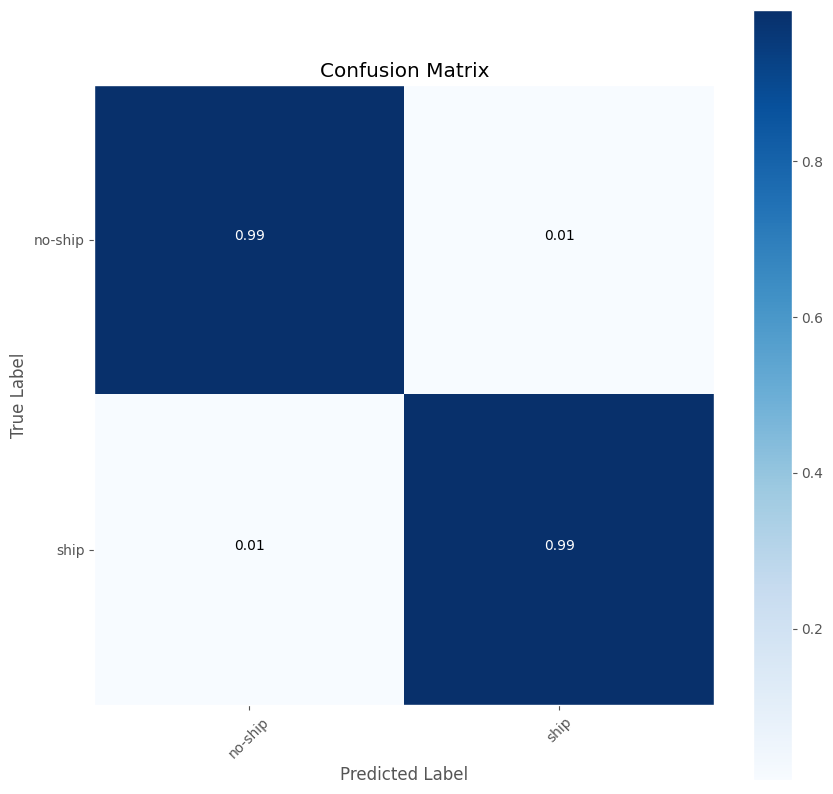

In [31]:
test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

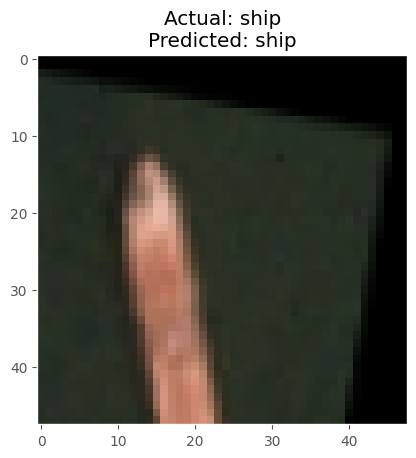

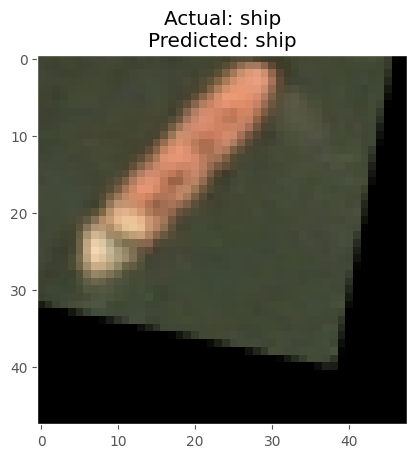

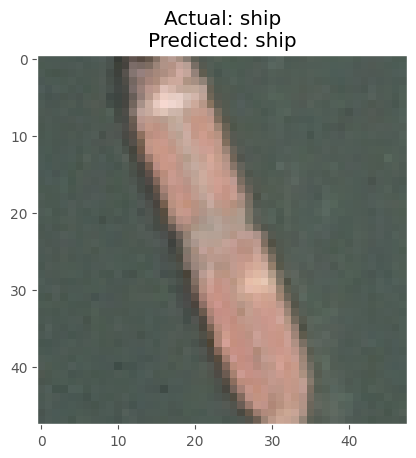

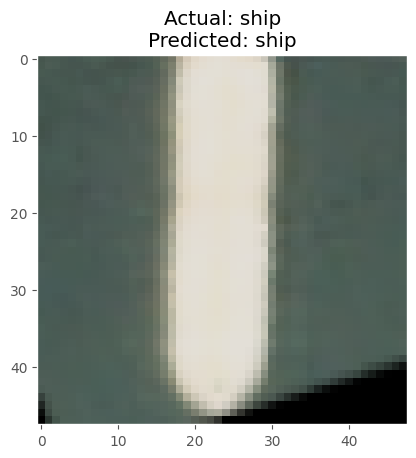

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


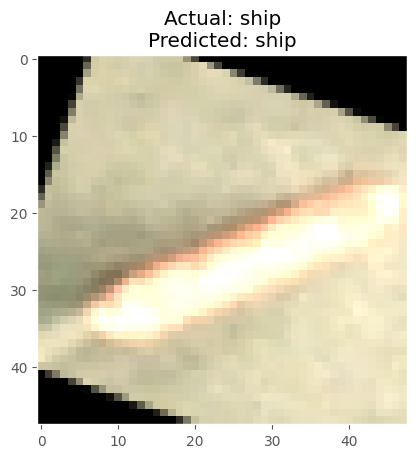

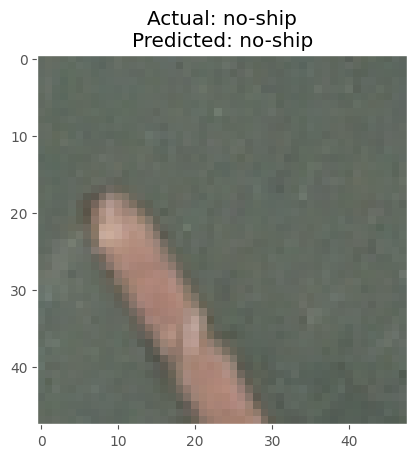

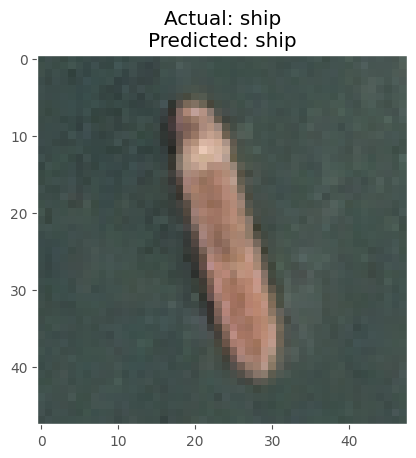

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


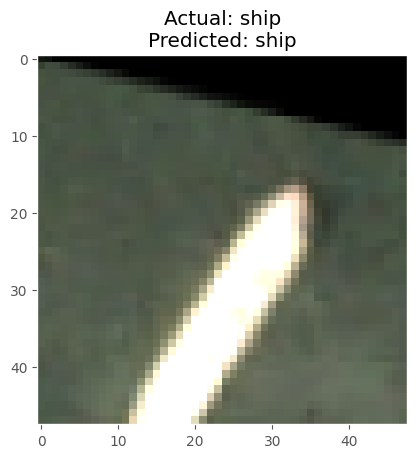

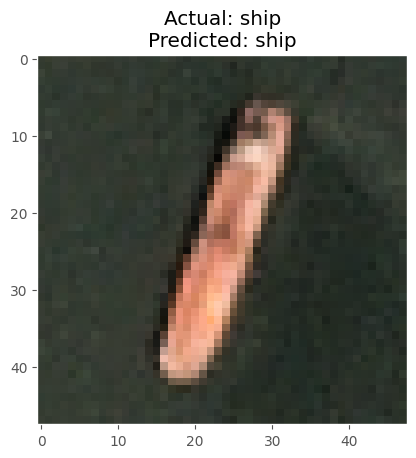

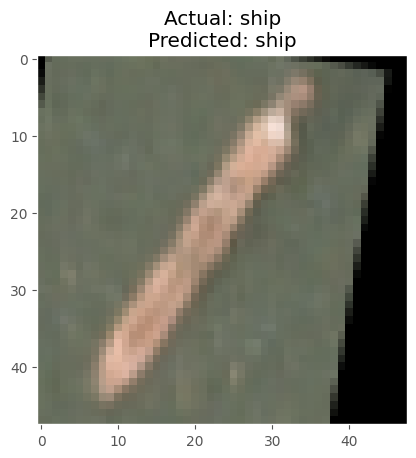

In [32]:
rnd_idx = random.sample(range(0,400),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):
    
    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass

In [33]:
model.save("ship-model.h5")